### Train XGBoost

In [1]:
import pandas as pd
from utils.constants import *
from sklearn.model_selection import KFold, StratifiedShuffleSplit,ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn import ensemble, svm, tree, linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, StandardScaler, QuantileTransformer, RobustScaler, PowerTransformer
from sklearn.metrics import root_mean_squared_error,root_mean_squared_log_error, r2_score, median_absolute_error,mean_absolute_percentage_error,mean_absolute_error, max_error
import xgboost as xgb
# REF: SCALERS -- https://medium.com/@daython3/scaling-your-data-using-scikit-learn-scalers-3d4b584107d7
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


In [2]:
from sklearn.preprocessing import LabelEncoder


In [3]:

## Flags
raw_data=False
impute_type = "simple"
impute_strategy = "median" # mean, median, most_frequent, constant, Callable 
impute_neighbours = 5
randome_state = 0
impute_max_iter= 10
scaler_type = "minmax"
model_type = "xgb"
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
       'engine_cap', 'depreciation', 'mileage', 'no_of_owners', 'type_of_vehicle_luxury sedan', 'type_of_vehicle_sports car', 
        'coe car', 'parf car', 
       'rare & exotic', 'emission_data']
CV_FOLDS = 5
# {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}  , epsilon = 0.1 ,C = 10
svr_kernel = 'rbf'
# Fold types
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Options (Can add more)
scaler_choice = {
    "minmax":  MinMaxScaler(),
    "robust": RobustScaler(),
    "standard": StandardScaler()
}

impute_choice = {
    "simple" : SimpleImputer(strategy=impute_strategy),
    "KNN" : KNNImputer(n_neighbors=impute_neighbours),
    "iterative": IterativeImputer(max_iter=impute_max_iter, random_state=randome_state)
}

model_choice  = {
            "decision_tree": tree.DecisionTreeRegressor(),
            "random_forest": ensemble.RandomForestRegressor(),
            "lr": linear_model.LinearRegression(),
            "knn": KNeighborsRegressor(),
            'gb': ensemble.GradientBoostingRegressor(),
            "svr": svm.SVR(kernel=svr_kernel ),
            "xgb": xgb.XGBRegressor(max_depth=5),
        }

# Do switching
if raw_data:
    test_size=0.2
    random_state=42
    shuffle=True
    orig_df = pd.read_csv(r"./dataset/train.csv")
    ## Split into train val split
    train_df, val_df = train_test_split(orig_df, test_size=test_size, random_state=random_state, shuffle=shuffle)

else:
    # Reading the dataset
    train_df = pd.read_csv(f"{local_path}/{folder}/{train_dataset}")
    val_df = pd.read_csv(f"{local_path}/{folder}/{val_dataset}")
# Get other scores
# [TODO] :: Should we add a missing indicator as well?
# from sklearn.impute import MissingIndicator
# indicator = MissingIndicator()
# missing_mask = indicator.fit_transform(X)

# Selection
imputer = impute_choice[impute_type]
scaler = scaler_choice[scaler_type]
model = model_choice[model_type]

# Average cv score -- limitation is that it does not give best model
# cv = cross_validate(model, X, y, cv=5, return_train_score=True)
# Prepare data

# le = LabelEncoder()
# train_df['color_code'] = le.fit_transform(train_df['type_of_vehicle'])
# val_df['color_code'] = le.transform(val_df['type_of_vehicle'])
# features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
#        'engine_cap', 'depreciation', 'mileage', 'no_of_owners', 'type_of_vehicle_luxury sedan', 'type_of_vehicle_sports car', 
#         'coe car', 'parf car', 'color_code',
#        'rare & exotic', 'emission_data']

train_df[features] = imputer.fit_transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])

# Fit and transform the numerical columns
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])

X_train = train_df[features].values
y_train = train_df['price'].values
print(X_train, y_train)
X_val = val_df[features].values
y_val = val_df['price'].values


[[0.08199325 0.14965986 0.27272727 ... 0.         0.         0.2       ]
 [0.02283105 0.09931973 0.27272727 ... 0.         0.         0.2       ]
 [0.0353385  0.10748299 0.27272727 ... 1.         0.         0.2       ]
 ...
 [0.02449871 0.09931973 0.27272727 ... 1.         0.         0.09285714]
 [0.04288267 0.6707483  0.63636364 ... 1.         1.         0.65714286]
 [0.05221362 0.27210884 0.27272727 ... 0.         0.         0.2       ]] [ 89800.    700.  64800. ...  73800. 649900.  53888.]


In [156]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2, 3],    # L2 regularization
}

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Set up the randomized search with RMSE as the scoring metric
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),  # Negative RMSE for maximizing
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best model and parameters
best_xgb = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [157]:
# Predict on the training and holdout sets
y_train_pred = best_xgb.predict(X_train)
y_val_pred = best_xgb.predict(X_val)

# Calculate metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_max_error = max_error(y_train, y_train_pred)

holdout_rmse = root_mean_squared_error(y_val, y_val_pred)
holdout_r2 = r2_score(y_val, y_val_pred)
holdout_mae = mean_absolute_error(y_val, y_val_pred)
holdout_max_error = max_error(y_val, y_val_pred)
holdout_mape = mean_absolute_percentage_error(y_val, y_val_pred)

# Print metrics to compare
print(f"train_rmse: {train_rmse}")
print(f"train_mae: {train_mae}")
print(f"train_max_error: {train_max_error}")

print(f"holdout_rmse: {holdout_rmse}")
print(f"holdout_r2: {holdout_r2}")
print(f"holdout_mae: {holdout_mae}")
print(f"holdout_max_error: {holdout_max_error}")
print(f"holdout_mape: {holdout_mape}")


train_rmse: 5312.303309430463
train_mae: 3484.2483990478518
train_max_error: 87442.25
holdout_rmse: 23890.263807468906
holdout_r2: 0.9722931506783882
holdout_mae: 6283.108578222656
holdout_max_error: 1075859.15625
holdout_mape: 0.0639109602392147


### Train RF

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


In [194]:

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=randome_state)

# Define parameter grid for RandomizedSearchCV specific to RandomForestRegressor
rf_param_distributions = {
    "n_estimators": [100, 200, 500, 1000],           # Number of trees in the forest
    "max_depth": [10, 20, 30, None],                 # Maximum depth of the tree
    "min_samples_split": [2, 5, 10],                 # Minimum number of samples required to split a node
    "min_samples_leaf": [1, 2, 4],                   # Minimum number of samples required at each leaf node
    "bootstrap": [True, False]                       # Whether to use bootstrap samples when building trees
}

# Set up the RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_distributions,
    n_iter=50,  # Number of random combinations to try
    scoring="neg_root_mean_squared_error",  # Use RMSE as the scoring metric
    cv=CV_FOLDS,
    verbose=1,
    n_jobs=-1,
    random_state=randome_state
)

# Fit RandomizedSearchCV on the training data
random_search_rf.fit(X_train, y_train)

# Update rf_model with the best model found by RandomizedSearchCV
rf_model = random_search_rf.best_estimator_

# Print best parameters and best score
print("Best parameters found by RandomizedSearchCV:", random_search_rf.best_params_)
print("Best cross-validated RMSE score:", -random_search_rf.best_score_)  # Negate to get RMSE in positive

# Evaluate on the hold-out set
y_pred = rf_model.predict(X_val)
y_train_pred = rf_model.predict(X_train)

# Metrics that we are tracking
train_rmse = root_mean_squared_error(y_train, y_train_pred)
holdout_rmse = root_mean_squared_error(y_val, y_pred)
holdout_r2 = r2_score(y_val, y_pred)
holdout_mae = mean_absolute_error(y_val, y_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
holdout_max_error = max_error(y_val, y_pred)
train_max_error = max_error(y_train, y_train_pred)
holdout_mape = mean_absolute_percentage_error(y_val, y_pred)

# Output metrics
print("scores: %f" % scores)
print("train_rmse: %f" % train_rmse)
print("train_mae: %f" % train_mae)
print("train_max_error: %f" % train_max_error)

print("holdout_rmse: %f" % holdout_rmse)
print("holdout_r2: %f" % holdout_r2)
print("holdout_mae: %f" % holdout_mae)
print("holdout_max_error: %f" % holdout_max_error)
print("holdout_mape: %f" % holdout_mape)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found by RandomizedSearchCV: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Best cross-validated RMSE score: 29688.72412656569
scores: -31731.155072
train_rmse: 10742.997288
train_mae: 2310.346017
train_max_error: 618775.016000
holdout_rmse: 27809.565221
holdout_r2: 0.962457
holdout_mae: 5900.277064
holdout_max_error: 1093527.583000
holdout_mape: 0.055594


In [8]:
rf_model = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_depth=5, bootstrap=True, random_state=randome_state)
rf_model.fit(X_train, y_train)
# Evaluate on the hold-out set
y_pred = rf_model.predict(X_val)
y_train_pred = rf_model.predict(X_train)

# Metrics that we are tracking
train_rmse = root_mean_squared_error(y_train, y_train_pred)
holdout_rmse = root_mean_squared_error(y_val, y_pred)
holdout_r2 = r2_score(y_val, y_pred)
holdout_mae = mean_absolute_error(y_val, y_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
holdout_max_error = max_error(y_val, y_pred)
train_max_error = max_error(y_train, y_train_pred)
holdout_mape = mean_absolute_percentage_error(y_val, y_pred)

# Output metrics
print("train_rmse: %f" % train_rmse)
print("train_mae: %f" % train_mae)
print("train_max_error: %f" % train_max_error)

print("holdout_rmse: %f" % holdout_rmse)
print("holdout_r2: %f" % holdout_r2)
print("holdout_mae: %f" % holdout_mae)
print("holdout_max_error: %f" % holdout_max_error)
print("holdout_mape: %f" % holdout_mape)


train_rmse: 33881.996529
train_mae: 20121.057338
train_max_error: 794113.225077
holdout_rmse: 40549.324648
holdout_r2: 0.920180
holdout_mae: 21221.693112
holdout_max_error: 1073441.227076
holdout_mape: 0.386290


### SHAP

In [202]:
train_df

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars,emission_data
0,1260733,Isuzu NPR85,isuzu,npr85,cheapest in the market! 14 feet full canopy wi...,2019.0,NaN,01-jul-2020,truck,premium ad car,...,0,0,0,0.0,1,0.0,0,0,0,0.200000
1,1289505,Honda Fit 1.3A G (COE till 06/2024),honda,fit,200,2009.0,NaN,12-aug-2009,hatchback,coe car,...,0,0,0,0.0,0,0.0,0,0,0,0.200000
2,1316182,Toyota Sienta 1.5A,toyota,sienta,non phv. excellent condition. 100% accident fr...,2018.0,NaN,28-may-2018,mpv,"parf car, premium ad car",...,0,0,0,1.0,1,0.0,0,0,0,0.200000
3,1310514,Volvo V40 T4 Momentum,volvo,v40,"well maintained! the safety, reliable and dura...",2018.0,NaN,30-aug-2019,hatchback,parf car,...,0,0,0,1.0,0,0.0,0,0,0,0.125000
4,1247893,Kia Carens 2.0A GDI,kia,carens,rare 1 owner unit! low km done! fully maintain...,2015.0,NaN,18-nov-2015,mpv,parf car,...,0,0,0,1.0,0,0.0,0,0,0,0.325000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1330095,BMW 3 Series 318i,bmw,318i,0,2015.0,NaN,26-feb-2016,luxury sedan,"parf car, consignment car, sgcarmart warranty ...",...,0,0,0,1.0,0,0.0,1,0,0,0.200000
19996,1300273,Nissan Qashqai 1.2A DIG-T,nissan,qashqai,"no repairs needed, buy and drive as it is! one...",2016.0,NaN,17-jun-2016,suv,"parf car, premium ad car",...,0,0,0,1.0,1,0.0,0,0,0,0.128571
19997,1316903,Honda Jazz 1.3A,honda,jazz,"1 owner, maintain by honda kah motor, at dicks...",2019.0,NaN,10-jul-2019,hatchback,parf car,...,0,0,0,1.0,0,0.0,0,0,0,0.092857
19998,1329593,Ferrari 488 GTB,ferrari,488,ital unit with warranty till dec 2024. fully s...,2016.0,NaN,03-nov-2016,sports car,"parf car, direct owner sale, rare & exotic, lo...",...,0,1,0,1.0,0,1.0,0,0,0,0.657143


In [203]:
train_df.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'original_reg_date', 'reg_date', 'type_of_vehicle', 'category',
       'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap',
       'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value',
       'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category',
       'features', 'accessories', 'indicative_price', 'price', 'reg_date_dt',
       'reg_date_year', 'reg_date_month', 'model_make', 'coe_age_left',
       'age_range', 'car_age', 'type_of_vehicle_bus/mini bus',
       'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
       'type_of_vehicle_mid-sized sedan', 'type_of_vehicle_mpv',
       'type_of_vehicle_others', 'type_of_vehicle_sports car',
       'type_of_vehicle_stationwagon', 'type_of_vehicle_suv',
       'type_of_vehicle_truck', 'type_of_vehicle_van', 'fuel_type_diesel',
       'fuel_type_diesel-electric', 'fuel_type_electric', 'fuel_type_petrol',
      

In [9]:
import shap

C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
explainer = shap.TreeExplainer(rf_model)


In [11]:
shap_values = explainer.shap_values(X_val)

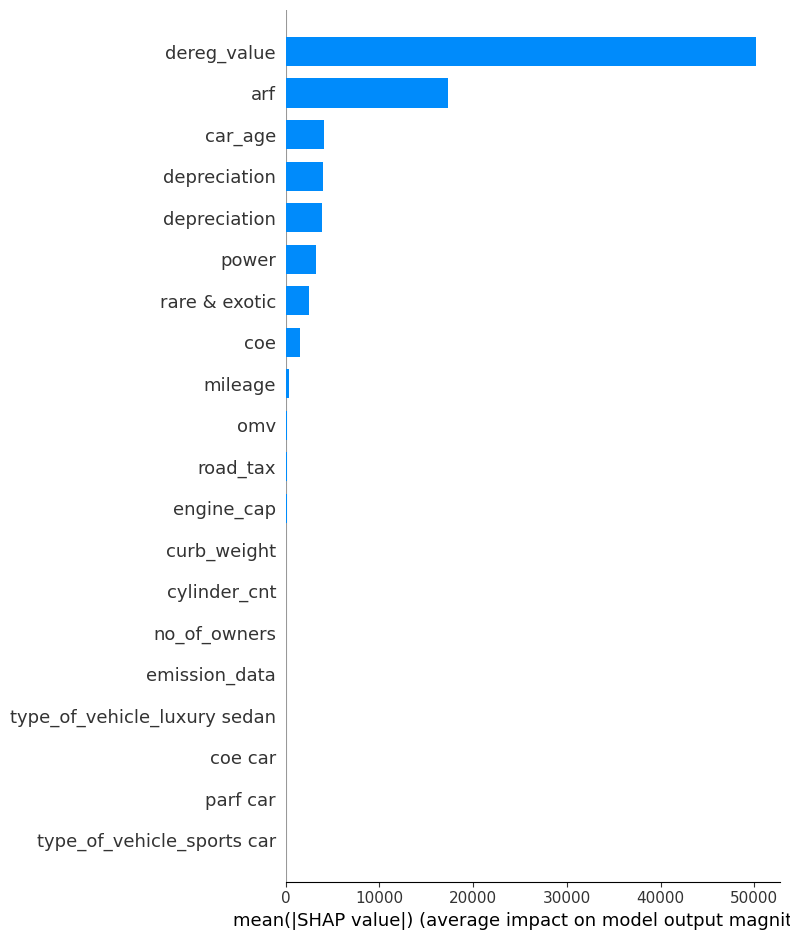

In [12]:
shap.summary_plot(shap_values, X_val, plot_type="bar", feature_names=features)


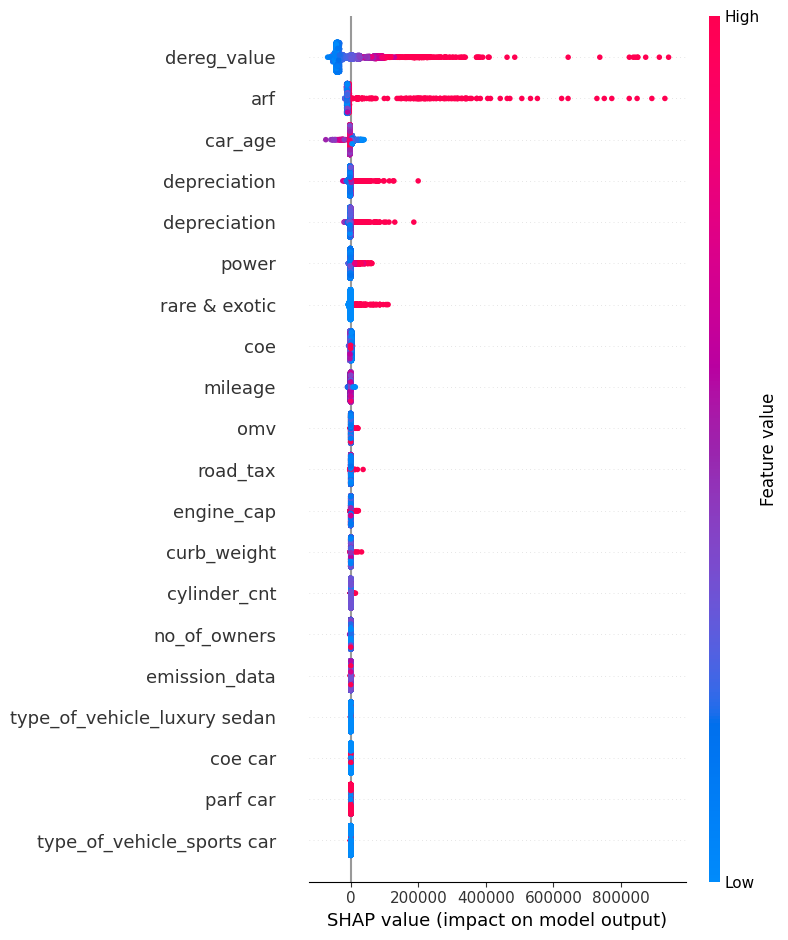

In [13]:
shap.summary_plot(shap_values, X_val, feature_names=features)


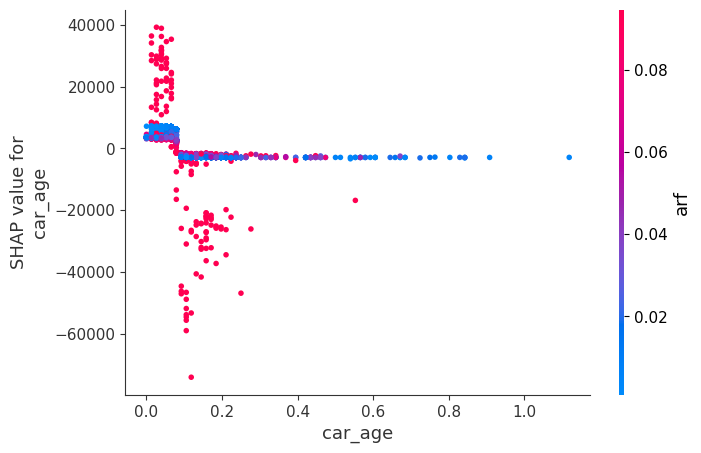

In [14]:
shap.dependence_plot('car_age', shap_values, X_val, feature_names=features, interaction_index='auto')


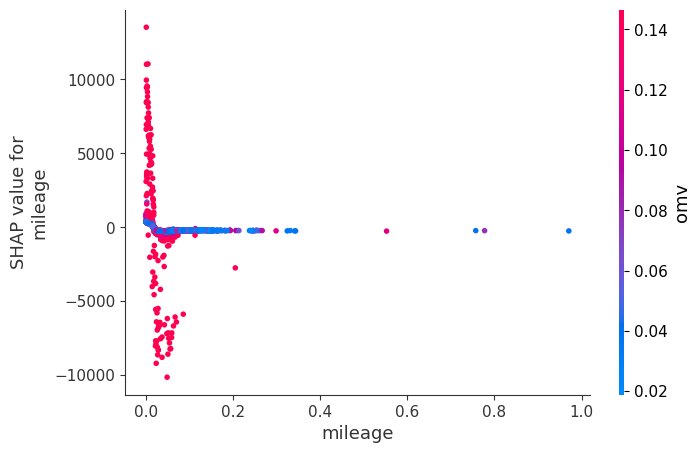

In [15]:
shap.dependence_plot('mileage', shap_values, X_val, feature_names=features, interaction_index='auto')


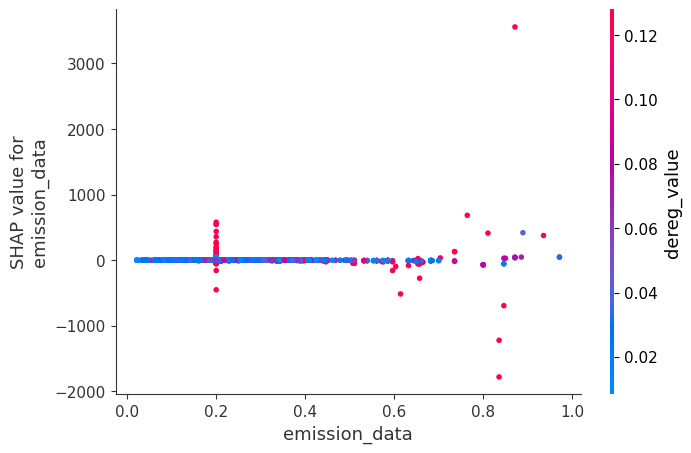

In [16]:
shap.dependence_plot('emission_data', shap_values, X_val, feature_names=features, interaction_index='auto')


### LIME

In [173]:
import lime
from lime.lime_tabular import LimeTabularExplainer
# Reading the dataset
train_df = pd.read_csv(f"{local_path}/{folder}/{train_dataset}")
val_df = pd.read_csv(f"{local_path}/{folder}/{val_dataset}")


# Selection
imputer = impute_choice[impute_type]
scaler = scaler_choice[scaler_type]
model = model_choice[model_type]

# Average cv score -- limitation is that it does not give best model
# cv = cross_validate(model, X, y, cv=5, return_train_score=True)
# Prepare data

# le = LabelEncoder()
# train_df['color_code'] = le.fit_transform(train_df['type_of_vehicle'])
# val_df['color_code'] = le.transform(val_df['type_of_vehicle'])
# features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
#        'engine_cap', 'depreciation', 'mileage', 'no_of_owners', 'type_of_vehicle_luxury sedan', 'type_of_vehicle_sports car', 
#         'coe car', 'parf car', 'color_code',
#        'rare & exotic', 'emission_data']

train_df[features] = imputer.fit_transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])

# Fit and transform the numerical columns
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])

X_train = train_df[features]
y_train = train_df['price']
X_val = val_df[features]
y_val = val_df['price']


In [175]:

# Initialize the explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    # class_names=data.target_names,  # Class names if it's a classification problem
    mode='regression'  # Set to 'regression' for regression models
)



In [191]:
# Choose an instance to explain (e.g., first instance in the test set)
j = 5
instance = X_val.iloc[j].values

explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=best_xgb.predict  # Use predict for regression
)
# Display the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

In [192]:
val_df.iloc[5:7]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars,emission_data
5,1326610,Honda HR-V 1.5A DX,honda,hr-v,one of the lowest depreciation in the market! ...,2018.0,NaN,17-may-2018,suv,parf car,...,0,0,0,1.0,0,0.0,0,0,0,0.2
6,1306534,Ferrari 488 Spider,ferrari,488,"single owner low mileage agent ital auto unit,...",2017.0,NaN,24-jul-2018,sports car,"parf car, premium ad car, low mileage car",...,0,1,0,1.0,1,0.0,0,0,0,0.2
